In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" # second gpu

#### Task 2
import pickle
import numpy as np
import time
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from scipy import interpolate
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

def TMSD(traj, t_lags):
    ttt = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags): 
        for p in range(len(traj)-t):
            ttt[idx] += (traj[p]-traj[p+t])**2            
        ttt[idx] /= len(traj)-t    
    return ttt

def aging(traj, twind):
    age = np.zeros(len(twind))
    for i, it in enumerate(twind):
        traj_seg = traj[0:it]
        age[i] = TMSD(traj_seg,[1])[0]
    return age

def bound(val):
    if val >= 100:
        val = 100
    elif val <= -100:
        val = -100
    else:
        val = val
    return val

def trajec_feature(traces):
    ## scaling factor
    if np.mean(np.abs(np.diff(traces))) != 0:
        sfac = (np.max(traces)-np.min(traces))/np.mean(np.abs(np.diff(traces)))
    else:
        sfac = 0
    
    mean = bound( np.mean(traces) )
    ms = bound( np.std(traces) )
    m3 = 0 ; m4 = 0
    if ms != 0:
        m3 = bound( np.mean(np.power(traces-mean,3))/(ms**3) )
        m4 = bound( np.mean(np.power(traces-mean,4))/(ms**4) )



    vtraces = np.diff(traces)
    vmean = bound( np.mean(vtraces) )
    vms = bound( np.std(vtraces) )
    vm3 = 0 ; vm4 = 0
    if vms != 0:
        vm3 = bound( np.mean(np.power(vtraces-vmean,3))/(vms**3) )
        vm4 = bound( np.mean(np.power(vtraces-vmean,4))/(vms**4) )

    atraces = np.diff(vtraces)
    amean = bound( np.mean(atraces) )
    ams = bound( np.std(atraces) )
    am3 = 0 ; am4 = 0
    if ams != 0:
        am3 = bound( np.mean(np.power(atraces-amean,3))/(ams**3) )
        am4 = bound( np.mean(np.power(atraces-amean,4))/(ams**4) )


    f2 = bound( np.max(vtraces) - np.min(vtraces) )
    f3 = bound( np.max(atraces) - np.min(atraces) )
    
       
    tlag = np.linspace(1, len(traces)-1, 10, dtype = 'int')
    
    msd = TMSD(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    nw1, nw0 = np.linalg.lstsq(A, np.log(msd), rcond=None)[0]

    nw1 = bound(nw1)
    nw0 = bound(nw0)
    
    tlag = np.linspace(10, len(traces)-1, 10, dtype = 'int')
    age = aging(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    age_nw1, age_nw0 = np.linalg.lstsq(A, np.log(age), rcond=None)[0]
    
    age_nw1 = bound(age_nw1)

    sh_stat, sh_p = shapiro(vtraces)
    
    if sh_p >= 0.1:
        sh_stat = -1      
    sh_stat = bound(sh_stat)
    
    if len(vtraces) > 20 :
        nom_stat, nom_p = normaltest(vtraces)
        if nom_p >= 0.1:
            nom_stat = -1
        and_result = anderson(vtraces).statistic
    
    else:
        nom_stat = -0.5
        and_result = -0.5
       
    nom_stat = bound(nom_stat)
    and_result = bound(and_result)

    
    feature = np.asarray([mean, ms, m3, m4, vmean, vms, vm3, vm4, \
                        amean, ams, am3, nw1, nw0, age_nw1, \
                        sfac, am4, f2, f3, sh_stat, and_result])
    
    

    feature = np.append(feature,msd)
    feature = np.append(feature,age)

    
    

    return feature



def label_gen(model_id, alpha):
    label = np.zeros(7)
    
    if model_id == 0 :
        label[0] = 1 
    if model_id == 1 :
        label[1] = 1 
    if model_id == 2 and alpha <= 1:
        label[2] = 1 
    if model_id == 3 :
        label[3] = 1 
    if model_id == 4 and alpha <= 1:
        label[4] = 1
        
    if model_id == 2 and alpha > 1:
        label[5] = 1 
    if model_id == 4 and alpha > 1:
        label[6] = 1
        
    if np.sum(label) != 1:
        print('label_error')
    
    return label


In [2]:
file = '../TRIAL/DATABASE/task_sim_1d_0.pkl'
nmax = 5000

f = open(file, 'rb')
my_list = pickle.load(f)

trajecs = my_list['trajec']
model_id = my_list['label_id']
labels = my_list['label']
elabels = my_list['elabel']

f.flush()
f.close()


ncase = int(len(trajecs)/nmax)


tstart = time.time()


ndiv = 100
namp = 0.001

data_set = np.zeros((len(trajecs),ndiv))
scaler = MinMaxScaler(feature_range=(0, 1))

for i in range(len(trajecs)):
    trajec = trajecs[i]
    ret = len(trajecs[i])
    convt = ndiv/ret
    
    ti_new = np.linspace(0, len(trajec), ndiv)
    postck = interpolate.splrep(np.arange(0, len(trajec), 1), trajec)
    trajec = interpolate.splev(ti_new, postck) 

    strajec = scaler.fit_transform(np.reshape(trajec,(-1,1))).T[0]       
    data_set[i] = strajec + namp * convt * np.random.normal(0,1,size=100)

    
tend = time.time()

print('data ready')
print('elapsed time: {0:.0f} min {1:.0f} sec'.format((tend-tstart)//60, (tend-tstart)%60))



data ready
elapsed time: 0 min 13 sec


In [3]:
train_size = 4000
test_size = 1000
f_dim = 40

idxs = np.arange(0, nmax, dtype='int')
np.random.shuffle(idxs)

idx = idxs[:train_size]
idx_test = idxs[train_size:train_size+test_size]

train_data = np.zeros((ncase*train_size,ndiv,1))
train_info = np.zeros((ncase*train_size,f_dim))
train_label = np.zeros((ncase*train_size,7))

test_data = np.zeros((ncase*test_size,ndiv,1))
test_info = np.zeros((ncase*test_size,f_dim))
test_label = np.zeros((ncase*test_size,7))



tstart = time.time()

icount = 0
for ic in range(ncase):
    for j, iid in enumerate(idx):
        train_data[icount,:,0] = data_set[ic*nmax+iid]
        train_info[icount] = trajec_feature(data_set[ic*nmax+iid]) 
        train_label[icount] = label_gen(labels[ic*nmax+iid], elabels[ic*nmax+iid])
        icount = icount + 1

icount = 0
for ic in range(ncase):
    for j, iid in enumerate(idx_test):
        test_data[icount,:,0] = data_set[ic*nmax+iid]
        test_info[icount] = trajec_feature(data_set[ic*nmax+iid]) 
        test_label[icount] = label_gen(labels[ic*nmax+iid], elabels[ic*nmax+iid])
        icount = icount + 1

tend = time.time()

print('elapsed time: {0:.0f} min {1:.0f} sec'.format((tend-tstart)//60, (tend-tstart)%60))



elapsed time: 1 min 43 sec


In [4]:
import tensorflow.keras as keras
import tensorflow as tf

keras.backend.clear_session()

machine_id = 0
estop_pat = 50
rlr_pat = 30

epnum = 1000
bsize = 128

l_dim = f_dim

MODEL_SAVE_FOLDER_PATH = './Final_build/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + 'task2_{0:}.hdf5'.format(machine_id)

checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode = 'max',\
                                verbose=1, save_best_only=True)

stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max', patience=estop_pat)
      
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=rlr_pat, min_lr=0.000001, \
                        verbose=1, min_delta=1e-5)





In [5]:
# act = 'selu'
# initializer = tf.keras.initializers.LecunNormal()
act = 'relu'
initializer = tf.keras.initializers.HeUniform()

def build_model_resnet(input_shape, l_dim):

    n_feature_maps = 128
#     n_feature_maps = 64
    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=10, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation(act)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=7, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation(act)(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation(act)(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=10, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation(act)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=7, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation(act)(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size =5, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation(act)(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=10, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation(act)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=7, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation(act)(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, strides=1,  \
                                 padding='same', kernel_initializer=initializer)(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation(act)(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(l_dim, activation=act)(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model


def MLP_read(l_dim, f_dim):

    l_input = keras.layers.Input(shape=(l_dim,))
    f_input = keras.layers.Input(shape=(f_dim,))
    concated = keras.layers.concatenate([l_input, f_input])

    mlp_clf = keras.models.Sequential()
    
    mlp_clf.add(keras.layers.Dense(100, activation='linear', input_dim=l_dim + f_dim, \
                                  kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))


    mlp_clf.add(keras.layers.Dense(100, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))


    mlp_clf.add(keras.layers.Dense(100, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))


    mlp_clf.add(keras.layers.Dense(50, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))


    mlp_clf.add(keras.layers.Dense(50, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))

    mlp_clf.add(keras.layers.Dense(50, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))

    mlp_clf.add(keras.layers.Dense(10, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))

    mlp_clf.add(keras.layers.Dense(10, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))

    mlp_clf.add(keras.layers.Dense(10, activation='linear', kernel_initializer=initializer))
    mlp_clf.add(keras.layers.BatchNormalization())
    mlp_clf.add(keras.layers.Activation(act))
    mlp_clf.add(keras.layers.Dropout(0.2))

    mlp_clf.add(keras.layers.Dense(7, activation='softmax'))
    
    out = mlp_clf(concated)

    mlp_model = keras.models.Model([l_input, f_input], out)

    return mlp_model


l_dim = f_dim

input_shape = (ndiv,1,)
res = build_model_resnet(input_shape, l_dim)
res.summary()
keras.utils.plot_model(res, to_file=MODEL_SAVE_FOLDER_PATH +'resnet.png', \
                       show_shapes=True, show_layer_names=True)

mlp_clf = MLP_read(l_dim, f_dim)
mlp_clf.summary()
keras.utils.plot_model(mlp_clf, to_file=MODEL_SAVE_FOLDER_PATH +'mlp_clf.png', \
                       show_shapes=True, show_layer_names=True)

indata = keras.layers.Input(shape=(ndiv,1,))
f_info = keras.layers.Input(shape=(f_dim,))

resnet_out = res(indata)
output = mlp_clf([resnet_out, f_info])


resnet_mlp = keras.models.Model([indata, f_info],output)
resnet_mlp.summary()
keras.utils.plot_model(resnet_mlp, to_file=MODEL_SAVE_FOLDER_PATH +'resnet_mlp.png', \
                       show_shapes=True, show_layer_names=True)


# from keras.utils import plot_model
resnet_mlp.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

hist = resnet_mlp.fit([train_data, train_info], train_label, batch_size=bsize, epochs=epnum,
                 verbose=1, validation_data=([test_data, test_info], test_label),\
                 callbacks=[rlr, stopping, checkpoint])     




Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 128)     1408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 128)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 80)           0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 7)            41177       concatenate[0][0]     

Epoch 18/1000
219/219 [==============================] - ETA: 0s - loss: 0.9461 - accuracy: 0.6520
Epoch 00018: val_accuracy did not improve from 0.73571
219/219 [==============================] - 26s 119ms/step - loss: 0.9461 - accuracy: 0.6520 - val_loss: 0.7816 - val_accuracy: 0.7349
Epoch 19/1000
219/219 [==============================] - ETA: 0s - loss: 0.9321 - accuracy: 0.6620
Epoch 00019: val_accuracy improved from 0.73571 to 0.75014, saving model to ./Final_build/task2_0.hdf5
219/219 [==============================] - 26s 119ms/step - loss: 0.9321 - accuracy: 0.6620 - val_loss: 0.7532 - val_accuracy: 0.7501
Epoch 20/1000
219/219 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.6724
Epoch 00020: val_accuracy improved from 0.75014 to 0.75443, saving model to ./Final_build/task2_0.hdf5
219/219 [==============================] - 26s 119ms/step - loss: 0.9095 - accuracy: 0.6724 - val_loss: 0.7383 - val_accuracy: 0.7544
Epoch 21/1000
219/219 [=================

Epoch 73/1000
219/219 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.7768
Epoch 00073: val_accuracy did not improve from 0.81500
219/219 [==============================] - 26s 117ms/step - loss: 0.7026 - accuracy: 0.7768 - val_loss: 0.6272 - val_accuracy: 0.8007
Epoch 74/1000
219/219 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.7740
Epoch 00074: val_accuracy did not improve from 0.81500
219/219 [==============================] - 26s 118ms/step - loss: 0.7088 - accuracy: 0.7740 - val_loss: 0.5981 - val_accuracy: 0.8084
Epoch 75/1000
219/219 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.7753
Epoch 00075: val_accuracy did not improve from 0.81500
219/219 [==============================] - 26s 118ms/step - loss: 0.7116 - accuracy: 0.7753 - val_loss: 0.6566 - val_accuracy: 0.7939
Epoch 76/1000
219/219 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.7769
Epoch 00076: val_accuracy did not imp

Epoch 129/1000
219/219 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.8125
Epoch 00129: val_accuracy did not improve from 0.82529
219/219 [==============================] - 26s 118ms/step - loss: 0.6132 - accuracy: 0.8125 - val_loss: 0.7216 - val_accuracy: 0.8119
Epoch 130/1000
219/219 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.8165
Epoch 00130: val_accuracy did not improve from 0.82529
219/219 [==============================] - 26s 118ms/step - loss: 0.6022 - accuracy: 0.8165 - val_loss: 0.6353 - val_accuracy: 0.8137
Epoch 131/1000
219/219 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.8174
Epoch 00131: val_accuracy improved from 0.82529 to 0.82657, saving model to ./Final_build/task2_0.hdf5
219/219 [==============================] - 26s 119ms/step - loss: 0.5988 - accuracy: 0.8174 - val_loss: 0.6437 - val_accuracy: 0.8266
Epoch 132/1000
219/219 [==============================] - ETA: 0s - loss: 0.5862 - ac

Epoch 157/1000
219/219 [==============================] - ETA: 0s - loss: 0.5511 - accuracy: 0.8351
Epoch 00157: val_accuracy did not improve from 0.82971
219/219 [==============================] - 26s 118ms/step - loss: 0.5511 - accuracy: 0.8351 - val_loss: 0.6947 - val_accuracy: 0.8271
Epoch 158/1000
219/219 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.8411
Epoch 00158: val_accuracy did not improve from 0.82971
219/219 [==============================] - 26s 118ms/step - loss: 0.5293 - accuracy: 0.8411 - val_loss: 0.6309 - val_accuracy: 0.8269
Epoch 159/1000
219/219 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.8388
Epoch 00159: val_accuracy did not improve from 0.82971
219/219 [==============================] - 26s 117ms/step - loss: 0.5395 - accuracy: 0.8388 - val_loss: 0.6899 - val_accuracy: 0.8279
Epoch 160/1000
219/219 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8388
Epoch 00160: val_accuracy did not

Epoch 185/1000
219/219 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8519
Epoch 00185: val_accuracy did not improve from 0.83500
219/219 [==============================] - 26s 118ms/step - loss: 0.4959 - accuracy: 0.8519 - val_loss: 0.7305 - val_accuracy: 0.8251
Epoch 186/1000
219/219 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.8519
Epoch 00186: val_accuracy did not improve from 0.83500
219/219 [==============================] - 26s 118ms/step - loss: 0.4967 - accuracy: 0.8519 - val_loss: 0.7688 - val_accuracy: 0.8331
Epoch 187/1000
219/219 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.8565
Epoch 00187: val_accuracy did not improve from 0.83500
219/219 [==============================] - 26s 119ms/step - loss: 0.4843 - accuracy: 0.8565 - val_loss: 0.7335 - val_accuracy: 0.8249
Epoch 188/1000
219/219 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8533
Epoch 00188: val_accuracy did not

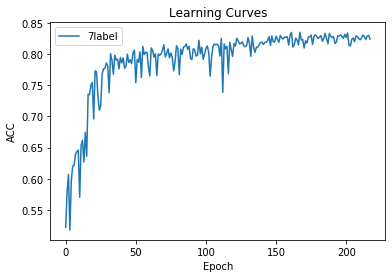

In [6]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.plot(hist.history['val_accuracy'], label='7label')
plt.savefig( MODEL_SAVE_FOLDER_PATH + 'learning_cur_task2.png')
plt.legend()
plt.show()

In [7]:

loaded = keras.models.load_model(model_path)


###############
file = '../TRIAL/DATABASE/task_sim_1d_1.pkl'
machine_id = 1
###############


f = open(file, 'rb')
my_list = pickle.load(f)
trajecs = my_list['trajec']
model_id = my_list['label_id']
labels = my_list['label']
f.flush()
f.close()

ndiv = 100
namp = 0.001

data_set = np.zeros((len(trajecs),ndiv))
scaler = MinMaxScaler(feature_range=(0, 1))

for i in range(len(trajecs)):
    trajec = trajecs[i]
    ret = len(trajecs[i])
    convt = ndiv/ret
    
    ti_new = np.linspace(0, len(trajec), ndiv)
    postck = interpolate.splrep(np.arange(0, len(trajec), 1), trajec)
    trajec = interpolate.splev(ti_new, postck) 

    strajec = scaler.fit_transform(np.reshape(trajec,(-1,1))).T[0]       
    data_set[i] = strajec + namp * convt * np.random.normal(0,1,size=100)



train_size = 3000
test_size = 2000
f_dim = 40

idxs = np.arange(0, nmax, dtype='int')
np.random.shuffle(idxs)
idx = idxs[:train_size]
idx_test = idxs[train_size:train_size+test_size]
train_data = np.zeros((ncase*train_size,ndiv,1))
train_info = np.zeros((ncase*train_size,f_dim))
train_label = np.zeros((ncase*train_size,7))
test_data = np.zeros((ncase*test_size,ndiv,1))
test_info = np.zeros((ncase*test_size,f_dim))
test_label = np.zeros((ncase*test_size,7))

tstart = time.time()
icount = 0
for ic in range(ncase):
    for j, iid in enumerate(idx):
        train_data[icount,:,0] = data_set[ic*nmax+iid]
        train_info[icount] = trajec_feature(data_set[ic*nmax+iid]) 
        train_label[icount] = label_gen(labels[ic*nmax+iid], elabels[ic*nmax+iid])
        icount = icount + 1

icount = 0
for ic in range(ncase):
    for j, iid in enumerate(idx_test):
        test_data[icount,:,0] = data_set[ic*nmax+iid]
        test_info[icount] = trajec_feature(data_set[ic*nmax+iid]) 
        test_label[icount] = label_gen(labels[ic*nmax+iid], elabels[ic*nmax+iid])
        icount = icount + 1

print('elapsed time: {0:.0f} min {1:.0f} sec'.format((tend-tstart)//60, (tend-tstart)%60))

estop_pat = 100
rlr_pat = 30

epnum = 1000
bsize = 128

l_dim = f_dim

MODEL_SAVE_FOLDER_PATH = './Final_build/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + 'task2_{0:}.hdf5'.format(machine_id)

checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode = 'max',\
                                verbose=1, save_best_only=True)

stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max', patience=estop_pat)
      
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=rlr_pat, min_lr=0.000001, \
                        verbose=1, min_delta=1e-5)


loaded.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

hist = loaded.fit([train_data, train_info], train_label, batch_size=bsize, epochs=epnum,
                 verbose=1, validation_data=([test_data, test_info], test_label),\
                 callbacks=[rlr, stopping, checkpoint])     


elapsed time: -95 min 14 sec
Epoch 1/1000
165/165 [==============================] - ETA: 0s - loss: 0.7910 - accuracy: 0.7558
Epoch 00001: val_accuracy improved from -inf to 0.81421, saving model to ./Final_build/task2_1.hdf5
165/165 [==============================] - 23s 139ms/step - loss: 0.7910 - accuracy: 0.7558 - val_loss: 0.6268 - val_accuracy: 0.8142
Epoch 2/1000
164/165 [============================>.] - ETA: 0s - loss: 0.7630 - accuracy: 0.7560
Epoch 00002: val_accuracy did not improve from 0.81421
165/165 [==============================] - 21s 129ms/step - loss: 0.7637 - accuracy: 0.7559 - val_loss: 0.5723 - val_accuracy: 0.8114
Epoch 3/1000
164/165 [============================>.] - ETA: 0s - loss: 0.7446 - accuracy: 0.7617
Epoch 00003: val_accuracy did not improve from 0.81421
165/165 [==============================] - 21s 128ms/step - loss: 0.7445 - accuracy: 0.7617 - val_loss: 0.5758 - val_accuracy: 0.8104
Epoch 4/1000
164/165 [============================>.] - ETA: 0s -

Epoch 28/1000
164/165 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.7928
Epoch 00028: val_accuracy did not improve from 0.82386
165/165 [==============================] - 21s 129ms/step - loss: 0.6547 - accuracy: 0.7926 - val_loss: 0.6025 - val_accuracy: 0.8102
Epoch 29/1000
164/165 [============================>.] - ETA: 0s - loss: 0.7653 - accuracy: 0.7569
Epoch 00029: val_accuracy did not improve from 0.82386
165/165 [==============================] - 21s 128ms/step - loss: 0.7654 - accuracy: 0.7568 - val_loss: 0.5732 - val_accuracy: 0.8201
Epoch 30/1000
164/165 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.7850
Epoch 00030: val_accuracy improved from 0.82386 to 0.82393, saving model to ./Final_build/task2_1.hdf5
165/165 [==============================] - 21s 130ms/step - loss: 0.6883 - accuracy: 0.7849 - val_loss: 0.5688 - val_accuracy: 0.8239
Epoch 31/1000
164/165 [============================>.] - ETA: 0s - loss: 0.7366 - accura

Epoch 56/1000
164/165 [============================>.] - ETA: 0s - loss: 0.5996 - accuracy: 0.8161
Epoch 00056: val_accuracy did not improve from 0.83464
165/165 [==============================] - 21s 129ms/step - loss: 0.6007 - accuracy: 0.8161 - val_loss: 0.5931 - val_accuracy: 0.8186
Epoch 57/1000
164/165 [============================>.] - ETA: 0s - loss: 0.6294 - accuracy: 0.8080
Epoch 00057: val_accuracy did not improve from 0.83464
165/165 [==============================] - 21s 128ms/step - loss: 0.6311 - accuracy: 0.8078 - val_loss: 0.6318 - val_accuracy: 0.8241
Epoch 58/1000
164/165 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.8028
Epoch 00058: val_accuracy did not improve from 0.83464
165/165 [==============================] - 21s 128ms/step - loss: 0.6307 - accuracy: 0.8028 - val_loss: 0.5805 - val_accuracy: 0.8141
Epoch 59/1000
164/165 [============================>.] - ETA: 0s - loss: 0.6136 - accuracy: 0.8094
Epoch 00059: val_accuracy did not imp

Epoch 84/1000
164/165 [============================>.] - ETA: 0s - loss: 0.5539 - accuracy: 0.8309
Epoch 00084: val_accuracy did not improve from 0.83557
165/165 [==============================] - 21s 129ms/step - loss: 0.5539 - accuracy: 0.8309 - val_loss: 0.5941 - val_accuracy: 0.8313
Epoch 85/1000
164/165 [============================>.] - ETA: 0s - loss: 0.5451 - accuracy: 0.8331
Epoch 00085: val_accuracy did not improve from 0.83557
165/165 [==============================] - 21s 129ms/step - loss: 0.5454 - accuracy: 0.8330 - val_loss: 0.6275 - val_accuracy: 0.8264
Epoch 86/1000
164/165 [============================>.] - ETA: 0s - loss: 0.5566 - accuracy: 0.8317
Epoch 00086: val_accuracy did not improve from 0.83557
165/165 [==============================] - 21s 129ms/step - loss: 0.5572 - accuracy: 0.8317 - val_loss: 0.5815 - val_accuracy: 0.8207
Epoch 87/1000
164/165 [============================>.] - ETA: 0s - loss: 0.6356 - accuracy: 0.8034
Epoch 00087: val_accuracy did not imp

164/165 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.8579
Epoch 00140: val_accuracy did not improve from 0.83557
165/165 [==============================] - 21s 128ms/step - loss: 0.4789 - accuracy: 0.8577 - val_loss: 0.6587 - val_accuracy: 0.8343
Epoch 141/1000
164/165 [============================>.] - ETA: 0s - loss: 0.4731 - accuracy: 0.8602
Epoch 00141: val_accuracy did not improve from 0.83557
165/165 [==============================] - 21s 129ms/step - loss: 0.4738 - accuracy: 0.8601 - val_loss: 0.6899 - val_accuracy: 0.8321
Epoch 142/1000
164/165 [============================>.] - ETA: 0s - loss: 0.4888 - accuracy: 0.8548
Epoch 00142: val_accuracy did not improve from 0.83557
165/165 [==============================] - 21s 129ms/step - loss: 0.4891 - accuracy: 0.8548 - val_loss: 0.6634 - val_accuracy: 0.8295
Epoch 143/1000
164/165 [============================>.] - ETA: 0s - loss: 0.4738 - accuracy: 0.8599
Epoch 00143: val_accuracy did not improve from 0

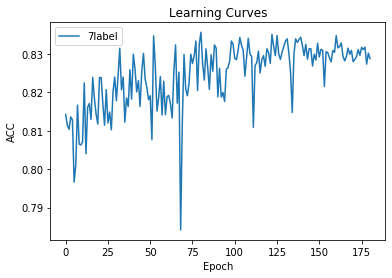

In [8]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.plot(hist.history['val_accuracy'], label='7label')
plt.savefig( MODEL_SAVE_FOLDER_PATH + 'learning_cur_task2_1.png')
plt.legend()
plt.show()